In [986]:
import pandas as pd
import numpy as np
import random
import io
import pickle
import twitter
import nltk
from nltk.classify import NaiveBayesClassifier
nltk.download("punkt")
nltk.download("stopwords")

import string
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
# Load list of NASDAQ stocks

nasdaq_list_df = pd.read_csv('./data/nasdaqlisted.txt', sep='|')

nasdaq_list_df.head()

,Symbol,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size,ETF,NextShares
0,AACG,ATA Creativity Global - American Depositary Sh...,G,N,N,100.0,N,N
1,AAL,"American Airlines Group, Inc. - Common Stock",Q,N,N,100.0,N,N
2,AAME,Atlantic American Corporation - Common Stock,G,N,N,100.0,N,N
3,AAOI,"Applied Optoelectronics, Inc. - Common Stock",G,N,N,100.0,N,N
4,AAON,"AAON, Inc. - Common Stock",Q,N,N,100.0,N,N


In [887]:
# Select out ETFs

nasdaq_list_df = nasdaq_list_df[nasdaq_list_df['ETF'] == 'N']

# Check for missing data
nasdaq_list_df[nasdaq_list_df.isnull().any(axis=1)]

,Symbol,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size,ETF,NextShares


In [979]:
# Select rows that are stocks

nasdaq_list_df = nasdaq_list_df[nasdaq_list_df['Security Name'].str.contains('Common Stock')]

# Create a csv file with single column of stock tickers to use for downloading stock closing prices

ticker_list_df = pd.DataFrame((nasdaq_list_df['Symbol']))
print(ticker_list_df.head())

# Output to csv file

ticker_list_df.to_csv('./data/ticker_list.csv', index=False, header=False)


  Symbol
1    AAL
2   AAME
3   AAOI
4   AAON
5   AAPL


In [889]:
# Load stock closing prices into a data frame

quotes_df = pd.read_csv('./data/quotes.csv')

In [890]:
# Reshape the stock price data frame so that each company's stock prices are rows with the dates as columns

quotes_df.set_index('Date', inplace=True)
quotes_df = quotes_df.transpose()
quotes_df.reset_index(inplace=True)
quotes_df.rename(columns = {'index':'Symbol'}, inplace = True)
quotes_df.head()

Date,Symbol,2019-11-15,2019-11-18,2019-11-19,2019-11-20,2019-11-21,2019-11-22
0,AAL,28.860001,28.600000,29.290001,28.230000,27.930000,28.680000
1,AAME,1.750000,1.570000,1.720000,1.910000,2.000000,1.950000
2,AAOI,10.865000,10.540000,10.250000,10.280000,10.200000,10.240000
3,AAON,50.340000,50.250000,50.689999,49.540001,48.369999,48.389999
4,AAPL,265.760010,267.100006,266.290009,263.190002,262.010010,261.779999


In [891]:
# Remove stocks with value below $25

quotes_df = quotes_df[quotes_df['2019-11-15'] > 25]

# Check for missing values

quotes_df.isnull().any().sum()

0

In [892]:
# Calculate percentange change over timeframe and add as column to the stock price dataframe

quotes_df['percent change'] = (quotes_df['2019-11-22'] - quotes_df['2019-11-15'])/quotes_df['2019-11-15'] * 100

In [893]:
# Add the company name as a new column since the company name will be used for 
# Twitter queries in addition to the ticker

quotes_df = pd.merge(quotes_df, nasdaq_list_df[['Symbol', 'Security Name']], on = 'Symbol', how ='inner')
quotes_df['Security Name'] = quotes_df['Security Name'].apply(lambda x: x.split(' -')[0].split(',')[0])

quotes_df.head()

,Symbol,2019-11-15,2019-11-18,2019-11-19,2019-11-20,2019-11-21,2019-11-22,percent change,Security Name
0,AAL,28.860001,28.600000,29.290001,28.230000,27.930000,28.680000,-0.623704,American Airlines Group
1,AAON,50.340000,50.250000,50.689999,49.540001,48.369999,48.389999,-3.873661,AAON
2,AAPL,265.760010,267.100006,266.290009,263.190002,262.010010,261.779999,-1.497596,Apple Inc.
3,AAWW,25.250000,25.049999,25.299999,24.389999,24.410000,25.010000,-0.950495,Atlas Air Worldwide Holdings
4,AAXN,67.370003,67.720001,68.480003,71.980003,71.900002,72.089996,7.006075,Axon Enterprise


In [1106]:
# Create lists of tickers and company names, selecting the top 30 gainers and top 30 decliners

negative_tickers = quotes_df.sort_values('percent change')['Symbol'][:30]
negative_companies = quotes_df.sort_values('percent change')['Security Name'][:30]
positive_tickers = quotes_df.sort_values('percent change', ascending=False)['Symbol'][:30]
positive_companies = quotes_df.sort_values('percent change', ascending=False)['Security Name'][:30]

In [895]:
# Initialize Twitter object for querying

Twitter=pickle.load(open('secret_twitter_credentials.pkl','rb'))

auth = twitter.oauth.OAuth(Twitter['Access Token'],
                           Twitter['Access Token Secret'],
                           Twitter['Consumer Key'],
                           Twitter['Consumer Secret'])

twitter_api = twitter.Twitter(auth=auth)

In [934]:
# Create a list of tweets for the top gainers, querying by ticker and by company name

positive_text = []
number = 500

for stock in positive_tickers:
    q = stock
    
    search_results = twitter_api.search.tweets(q=q, count=number)

    statuses = search_results['statuses']
    for s in statuses:
        symbol = s['entities']['symbols']
        if len(symbol) == 1 and symbol[0]['text'] == stock:
            if not s["text"] in positive_text:
                positive_text.append(s['text'])

for company in positive_companies:
    q = company
    
    search_results = twitter_api.search.tweets(q=q, count=number)

    statuses = search_results['statuses']
    for s in statuses:
        if s['lang'] == 'en' and not s["text"] in positive_text:
            positive_text.append(s['text'])


In [936]:
# Create a list of tweets for the top decliners, querying by ticker and by company name

negative_text = []
number = 500

for stock in negative_tickers:
    q = stock
    
    search_results = twitter_api.search.tweets(q=q, count=number)

    statuses = search_results['statuses']
    for s in statuses:
        symbol = s['entities']['symbols']
        if len(symbol) == 1 and symbol[0]['text'] == stock:
            if not s["text"] in negative_text:
                negative_text.append(s['text'])

for company in negative_companies:
    q = company
    
    search_results = twitter_api.search.tweets(q=q, count=number)

    statuses = search_results['statuses']
    for s in statuses:
        if s['lang'] == 'en' and not s["text"] in negative_text:
            negative_text.append(s['text'])

In [1097]:
# Create bag of words for positive and negative sentiments, filtering out stop words

# Standard stop words

useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)

# Additional words found examining analysis results

useless_words.extend(['https', 'http', 'inc.', 'inc', 'the', 'rt', '…', '“', '”', '’', "'s"])

# To filter out stock tickers

useless_words.extend(negative_tickers.str.lower())
useless_words.extend(positive_tickers.str.lower())


def bag_of_words_features(text):
    return {word:1 for word in text if not word.lower() in useless_words\
           and '/' not in word}

positive_features = [
    (bag_of_words_features(nltk.word_tokenize(text)), 'pos') \
    for text in positive_text
]

negative_features = [
    (bag_of_words_features(nltk.word_tokenize(text)), 'neg') \
    for text in negative_text
]

print(f'Number of positive features: {len(positive_features)}')
print(f'Number of negative features: {len(negative_features)}')

Number of positive features: 1486
Number of negative features: 1300


In [1098]:
# Shuffle both list of features to ensure that each company has tweets in both the training and test datasets

random.shuffle(positive_features)
random.shuffle(negative_features)

# Create model with training dataset
split = int(1300 * .8)
sentiment_classifier = NaiveBayesClassifier.train(positive_features[:split]+negative_features[:split])

In [1099]:
# Evaluate the accuracy of the model on the training dataset
e
nltk.classify.util.accuracy(sentiment_classifier, positive_features[:split]+negative_features[:split])*100

98.26923076923076

In [1100]:
# Evaluate the accuracy of the model on the testing dataset

nltk.classify.util.accuracy(sentiment_classifier, positive_features[split:]+negative_features[split:])*100

88.38526912181302

In [1101]:
# Print the most informative features

sentiment_classifier.show_most_informative_features()

Most Informative Features
         Pharmaceuticals = 1                 pos : neg    =     49.7 : 1.0
                  rating = 1                 pos : neg    =     40.3 : 1.0
                 changed = 1                 pos : neg    =     37.7 : 1.0
                    Care = 1                 pos : neg    =     20.3 : 1.0
                 Applied = 1                 neg : pos    =     19.4 : 1.0
               Materials = 1                 neg : pos    =     19.4 : 1.0
                Upgraded = 1                 pos : neg    =     17.7 : 1.0
                    zone = 1                 neg : pos    =     15.7 : 1.0
              Bankshares = 1                 neg : pos    =     15.4 : 1.0
                  market = 1                 pos : neg    =     13.4 : 1.0


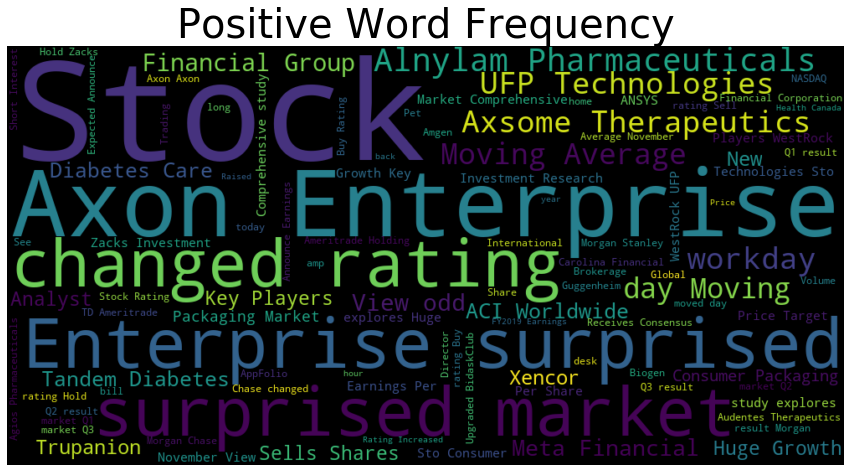

In [1107]:
# Create a filtered list of all the words in the positive tweets to be used for plotting

positive_words = []
for line in positive_text:
    positive_words.extend([word for word in nltk.word_tokenize(line) if word.lower() not in useless_words\
     and '/' not in word])
    
# Create a word cloud displaying the top 100 positive words

unique_string=(" ").join(positive_words)
wordcloud = WordCloud(width = 1000, height = 500, max_words = 100).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Word Frequency", fontsize = 40)
plt.savefig('positive_word_plot.png', bbox_inches='tight')
plt.show()
plt.close()

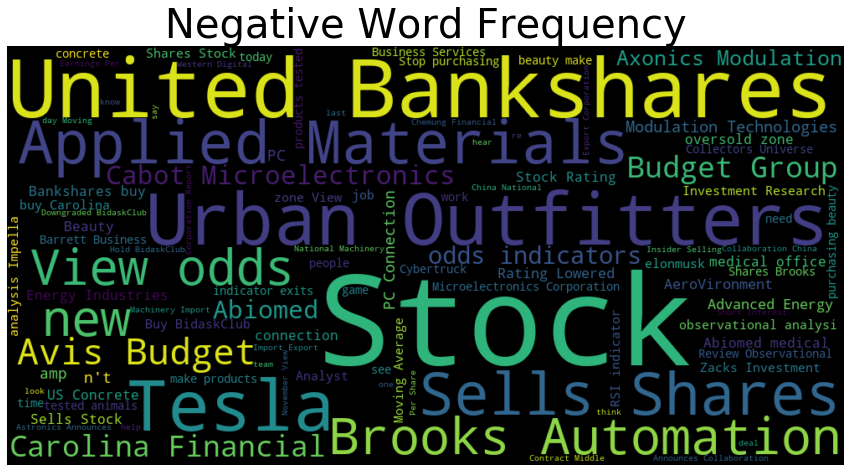

In [1105]:
# Create a filtered list of all the words in the positive tweets to be used for plotting

negative_words = []
for line in negative_text:
    negative_words.extend([word for word in nltk.word_tokenize(line) if word.lower() not in useless_words\
     and '/' not in word])

# Create a word cloud displaying the top 100 positive words

unique_string=(" ").join(negative_words)
wordcloud = WordCloud(width = 1000, height = 500, max_words = 100).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Word Frequency", fontsize = 40)
plt.savefig('negative_word_plot.png', bbox_inches='tight')
plt.show()
plt.close()